# Bayesian Convolutional Neural Networks for Histopathological Image Classification

In [1]:
import torch
import csv
import os
import sys
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from torch.utils import data
from torchvision import transforms
from torchvision.transforms import ToTensor

In [2]:
# locate the modules required for Bayesian CNNs
sys.path.append('../PyTorch-BayesianCNN/Image Recognition/')

from utils.BBBlayers import GaussianVariationalInference
from utils.BayesianModels.BayesianLeNet import BBBLeNet

In [3]:
skip_training = False

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

print('using cuda: {}'.format(use_cuda))

using cuda: True


In [5]:
# csv which contains the IDs and labels for the training data
label_path = 'kaggle/train_labels.csv'

# we make a dictionary called labels, which pairs each ID with its label
with open(label_path, mode='r') as file:
    reader = csv.reader(file)
    next(reader) # skip the header
    labels = {row[0]: int(row[1]) for row in reader}

# we also store all the labels in a separate list
list_IDs = list(labels.keys())

In [6]:
# we use the Torch Dataset class to efficiently handle the data
class Dataset(data.Dataset):
    def __init__(self, list_IDs, labels, transform):
        self.labels = labels
        self.list_IDs = list_IDs
        self.transform = transform
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        filename = '{}.tif'.format(ID)
        
        filepath = os.path.join('kaggle', 'train', filename)
        image = Image.open(filepath)
        X = self.transform(image)
        y = self.labels[ID]
        
        return X, y

In [7]:
validation_split = 0.1
max_epochs = 5
num_samples = 10
resize = 32
beta_type = "Blundell"

In [8]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(resize),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

training_set = Dataset(list_IDs, labels, transform=transform)

In [9]:
n_train = len(training_set)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(validation_split * n_train))

training_IDs, validation_IDs = indices[split:], indices[:split]

loader_params = {'batch_size': 32,
         'num_workers': 6}

In [10]:
training_sampler = data.SubsetRandomSampler(training_IDs)
validation_sampler = data.SubsetRandomSampler(validation_IDs)

training_loader = data.DataLoader(training_set, **loader_params,
                                 sampler=training_sampler)
validation_loader = data.DataLoader(training_set, **loader_params,
                                 sampler=validation_sampler)

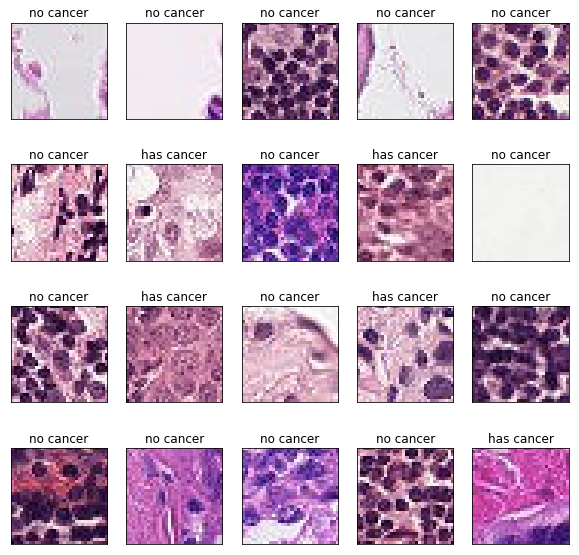

In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(training_loader)
# obtain one batch of training images
images, labels = dataiter.next()
classes = ['no cancer', 'has cancer']

# plot a sample of 20 images from the batch along with labels
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [12]:
inputs = 3 # number of input channels
outputs = 2 # number of output classes

lr = 0.001
weight_decay = 0.0005

net = BBBLeNet(outputs, inputs)

net.to(device)

vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [13]:
# Feed a batch of images from the training data to test the network
with torch.no_grad():
    dataiter = iter(training_loader)
    images, labels = dataiter.next()
    data = images.view(-1, inputs, 32, 32).repeat(num_samples, 1, 1, 1)
    labels = labels.repeat(num_samples)
    data = data.to(device)
    labels = labels.to(device)
    print('Shape of the input tensor:', data.shape)

    y, kl = net.probforward(data)
    # print(y)
    # print(kl)
    assert y.shape == torch.Size([32 * num_samples, 2]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')

Shape of the input tensor: torch.Size([320, 3, 32, 32])
The shapes seem to be ok.


In [14]:
ckpt_name = f'model_LeNet_full_bayesian.pt'
ckpt_name

'model_LeNet_full_bayesian.pt'

In [15]:
%%time

batch_size = loader_params['batch_size']

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, max_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    m = math.ceil(len(training_set) / batch_size)
    
    ###################
    # train the model #
    ###################
    net.train()
    for batch_idx, (data, target) in enumerate(training_loader):
        # move tensors to GPU if CUDA is available
        
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (max_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,kl = net.probforward(data)
        # calculate the batch loss
        loss = vi(output, target, kl, beta)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += (loss.item()*data.size(0)) / num_samples
        
    # print('output: {}'.format(output))
    # print('kl: {}'.format(kl))
    ######################    
    # validate the model #
    ######################
    net.eval()
    for batch_idx, (data, target) in enumerate(validation_loader):
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,kl = net.probforward(data)
        # calculate the batch loss
        loss = vi(output, target, kl, beta)

        # update average validation loss 
        valid_loss += (loss.item()*data.size(0)) / num_samples
        
        break
    
    # print('loss: {}'.format(loss))
    # print(loss.item())
    # print(data.size(0))
    # print(num_samples)
    # print(valid_loss)
        
    # calculate average losses
    train_loss = train_loss/(len(training_loader.dataset) * (1-validation_split))
    valid_loss = valid_loss/(len(validation_loader.dataset) * validation_split)
        
    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), ckpt_name)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 17.850963 	Validation Loss: 0.000935
Validation loss decreased (inf --> 0.000935).  Saving model ...
Epoch: 2 	Training Loss: 17.902948 	Validation Loss: 0.000708
Validation loss decreased (0.000935 --> 0.000708).  Saving model ...
Epoch: 3 	Training Loss: 39.723144 	Validation Loss: 0.000562
Validation loss decreased (0.000708 --> 0.000562).  Saving model ...
Epoch: 4 	Training Loss: 49.051866 	Validation Loss: 0.000723
Epoch: 5 	Training Loss: 54.067720 	Validation Loss: 0.000669
CPU times: user 33min 6s, sys: 41.5 s, total: 33min 47s
Wall time: 8min 30s


In [16]:
net.load_state_dict(torch.load(ckpt_name))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [17]:
def calc_uncertainity(output):
    prediction = F.softmax(output, dim = 1)
    results = torch.max(prediction, 1 )
    p_hat = results[0].detach().cpu()
    p_hat = np.array(p_hat)
    epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
    epistemic += epistemic 
    #print (epistemic)
    aleatoric = np.mean(p_hat * (1-p_hat), axis = 0)
    aleatoric += aleatoric
    #print (aleatoric)
    return epistemic, aleatoric

In [18]:
##THIS IS FOR DEVELOPMENT PURPOSES
test_loader = validation_loader

In [19]:
%%time

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

net.eval()
#m = math.ceil(len(test_data) / batch_size)
m = math.ceil(len(validation_IDs) / batch_size)
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    
    data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
    target = target.repeat(num_samples)
    # move tensors to GPU if CUDA is available
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    
    if beta_type is "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif beta_type is "Soenderby":
        beta = min(epoch / (max_epochs // 4), 1)
    elif beta_type is "Standard":
        beta = 1 / m
    else:
        beta = 0
    # forward pass: compute predicted outputs by passing inputs to the model
    output, kl = net.probforward(data)
    # calculate the batch loss
    loss = vi(output, target, kl, beta)
    # update test loss 
    test_loss += loss.item()*data.size(0) / num_samples
    #test_loss += loss.item()
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1) 
    
    epistemic , aleatoric = calc_uncertainity(output)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i >= target.data.shape[0]: # batch_size could be greater than left number of images
            break
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
#epistemic = epistemic/len(test_loader.dataset)
print('Epistemic Uncertainty: {:.6f}\n'.format(epistemic))
#aleatoric = aleatoric/len(test_loader.dataset)
print('Aleatoric Uncertainty: {:.6f}\n'.format(aleatoric))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 43.845122

Epistemic Uncertainty: 0.025352

Aleatoric Uncertainty: 0.357674

Test Accuracy of no cancer: 77% (10208/13101)
Test Accuracy of has cancer: 77% (6868/8915)

Test Accuracy (Overall): 77% (17076/22016)
CPU times: user 28.7 s, sys: 721 ms, total: 29.4 s
Wall time: 7.58 s
